# 強化学習

In [1]:
from __future__ import division
import numpy as np
import random
import warnings
import pandas as pd
import math
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import tqdm

## 多腕バンディット問題

### greedy algorithm

In [2]:
def greedy(trials, rewards, n):
    """
    @param trials each arm's trial num
    @param rewards each arm's reward
    @param n greedy algorithm parameter
    @return selected arm position
    """
    if np.min(trials) < n:
        return np.argmin(trials)
    else:
        return np.argmax(rewards / trials)

### ε-greedy algorithm

In [3]:
def eps_greedy(trials, rewards, eps):
    """
    @param trials each arm's trial num
    @param rewards each arm's reward
    @param eps ε-greedy algorithm parameter
    @return selected arm position
    """
    if np.min(trials) == 0:
        return np.argmin(trials)
    elif np.random.rand() < eps:
        return np.random.randint(len(trials))
    else:
        return np.argmax(rewards / trials)

### 楽観的初期値法(optimistic initial values)

In [4]:
def optimistic_init_val(trials, rewards, r_sup):
    """
    @param trials each arm's trial num
    @param rewards each arm's reward
    @param r_sup optimistic initial values algorithm parameter
    @return selected arm position
    """
    K = len(trials)
    return np.argmax((trials+K*r_sup)/(reward+K))

### UCB1 (Upper Confidence Bound) algorithm

In [5]:
def UCB1(trials, rewards, R):
    """
    @param trials each arm's trial num
    @param rewards each arm's reward
    @param R UCB1 algorithm parameter
    @return selected arm position
    """
    if np.min(trials) == 0:
        return np.argmin(trials)
    mu = rewards / trials
    U = R * np.sqrt((2*np.log(np.sum(trials)))/trials)
    return np.argmax(mu+U) 

### スロットの定義

In [10]:
class slot(object):
    def __init__(self, name, prob_reward_lst):
        self.name = name
        self.convert_pr_lst(prob_reward_lst)
        
    def convert_pr_lst(self, prob_reward_lst):
        start = 0
        self.pr_range = []
        for ele in prob_reward_lst:
            self.pr_range.append([[start, start+ele[0]], ele[1]])
            start += ele[0]
        if not start == 1: #もし確率が1出なかったらエラー
            warnings.warn('Illegal reward function!!!')
    
    def turn(self):
        prob = np.random.rand()
        for ele in self.pr_range:
            if (ele[0][0] <= prob) and (prob <= ele[0][1]):
                return ele[1]

### ゲームの定義

In [41]:
R = 20
PLAY_NUM = 100
TIME_STEP = 10000

arm_a  = slot("a", [[0.2, R], [0.8, 0]])
arm_b  = slot("b", [[0.3, R], [0.7, 0]])
arm_c  = slot("c", [[0.4, R], [0.6, 0]])
arm_d  = slot("d", [[0.5, R], [0.5, 0]])

arms = np.array([arm_a, arm_b, arm_c, arm_d])
average_rewards = np.zeros(TIME_STEP) #length TIME_STEP
selected_arms = np.zeros((TIME_STEP, len(arms))) #length len(arms) * TIME_STEP

for i in tqdm.tqdm(range(PLAY_NUM)):
    trials = np.zeros(len(arms))
    rewards = np.zeros(len(arms))
    
    for j in xrange(TIME_STEP):
        arm = UCB1(trials, rewards, R) #多腕バンディットアルゴリズム
        reward = arms[arm].turn()
        trials[arm] += 1
        rewards[arm] += reward
        selected_arms[j, arm] += 1
        average_rewards[j] += reward
        
average_rewards = np.array(average_rewards) / PLAY_NUM
selected_arms = np.array(selected_arms) / PLAY_NUM

100%|██████████| 100/100 [00:31<00:00,  3.22it/s]


### 結果の描画

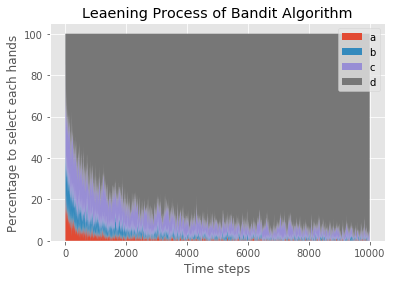

In [42]:
selected_arms = np.array(selected_arms) * 100 #パーセントにキャスト
x = np.arange(TIME_STEP)
# スタックプロット
fig, ax = plt.subplots()
ax.stackplot(x, selected_arms.T, labels=["a","b","c","d"])
plt.legend()
plt.title("Leaening Process of Bandit Algorithm")
plt.xlabel("Time steps")
plt.ylabel("Percentage to select each hands")
plt.show()

## 割引報酬和

In [ ]:
class finite_MDP: